Epoch 1/5
582/582 [==============================] - 135s 229ms/step - loss: 0.7542 - accuracy: 0.5220 - val_loss: 0.6928 - val_accuracy: 0.5129
Epoch 2/5
582/582 [==============================] - 154s 264ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6919 - val_accuracy: 0.5593
Epoch 3/5
582/582 [==============================] - 126s 217ms/step - loss: 0.6459 - accuracy: 0.6231 - val_loss: 0.5334 - val_accuracy: 0.7296
Epoch 4/5
582/582 [==============================] - 124s 212ms/step - loss: 0.4931 - accuracy: 0.7631 - val_loss: 0.4657 - val_accuracy: 0.7816
Epoch 5/5
582/582 [==============================] - 123s 212ms/step - loss: 0.4145 - accuracy: 0.8092 - val_loss: 0.4706 - val_accuracy: 0.7859


Number of Adversarial Images: 32


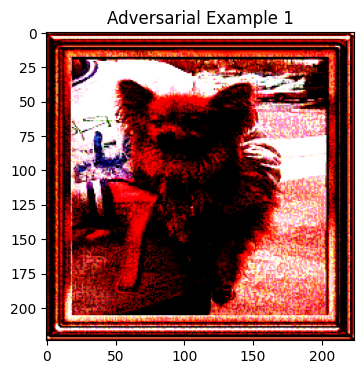

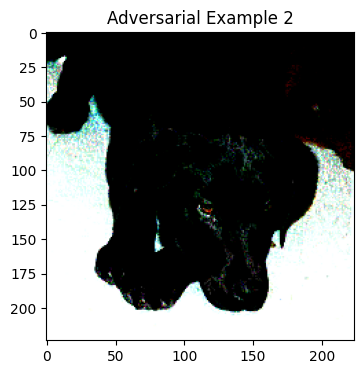

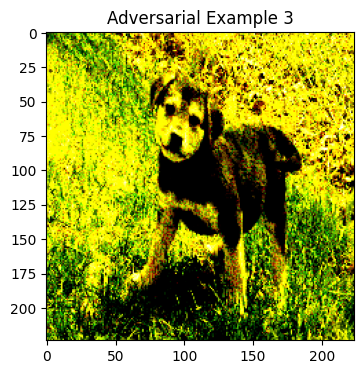

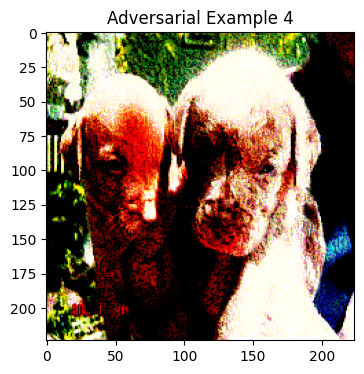

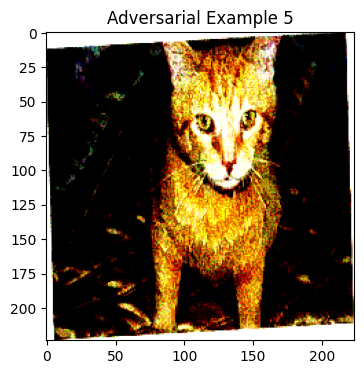

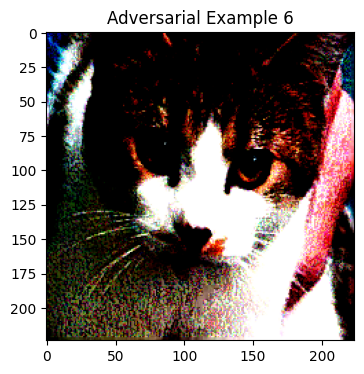

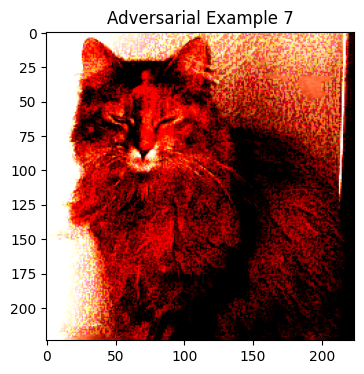

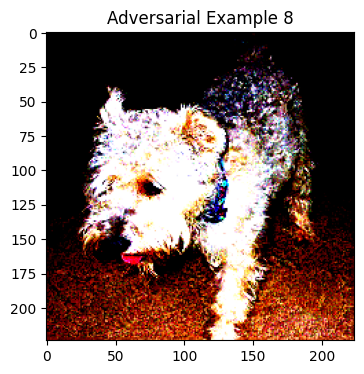

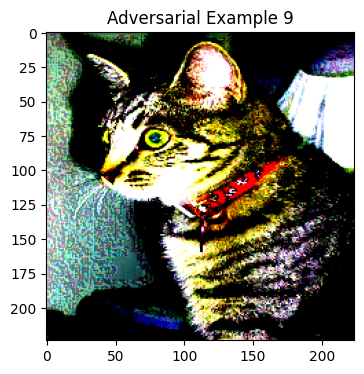

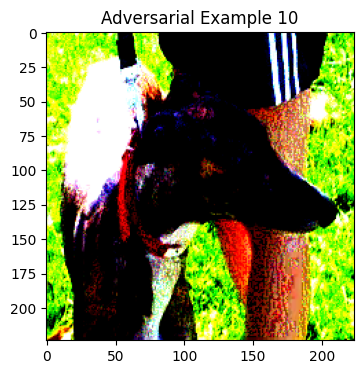

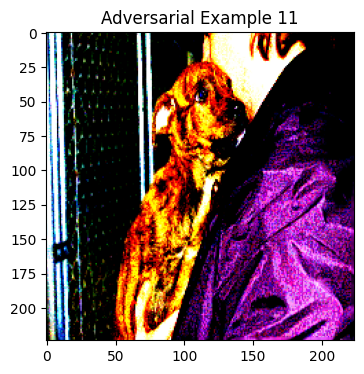

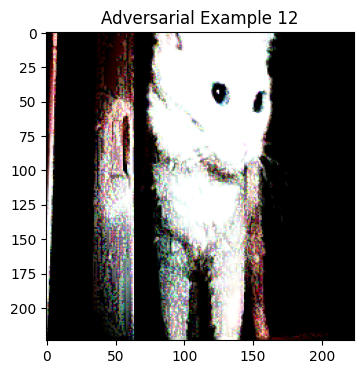

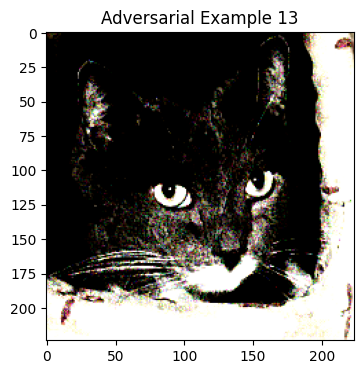

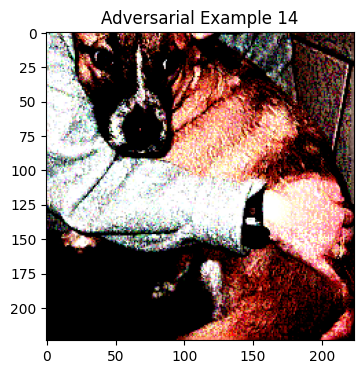

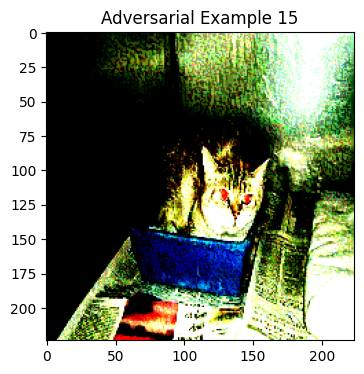

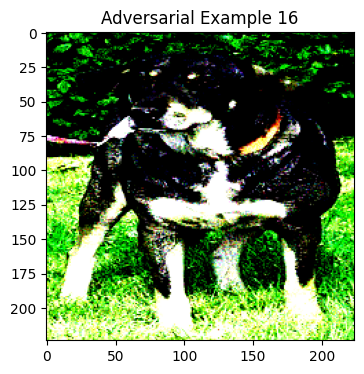

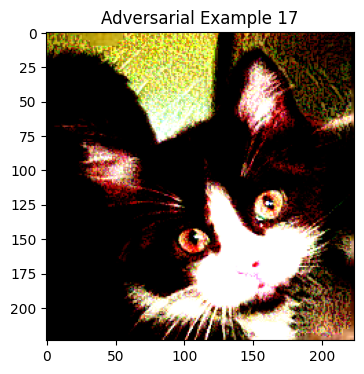

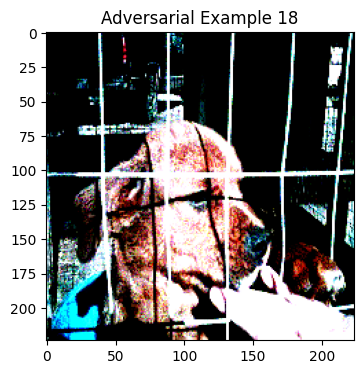

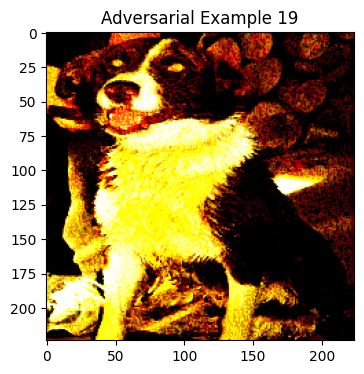

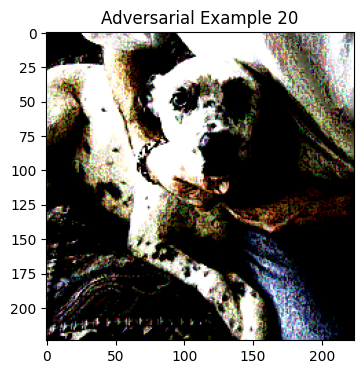

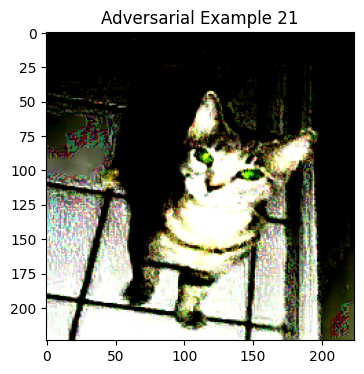

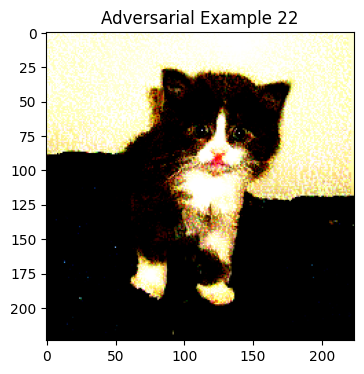

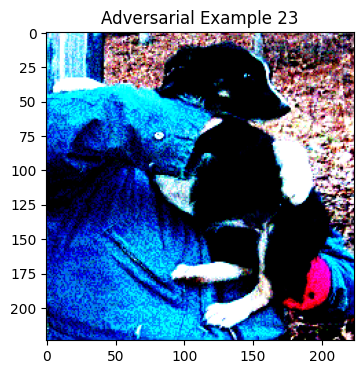

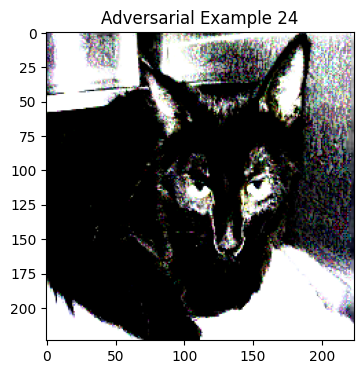

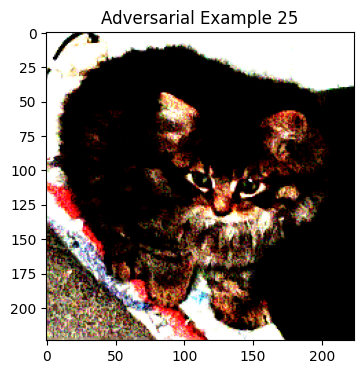

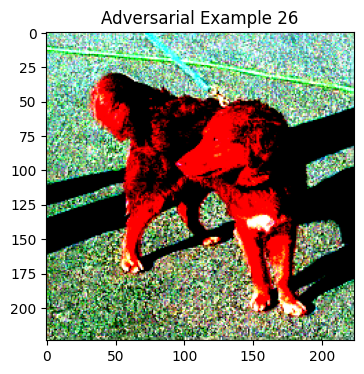

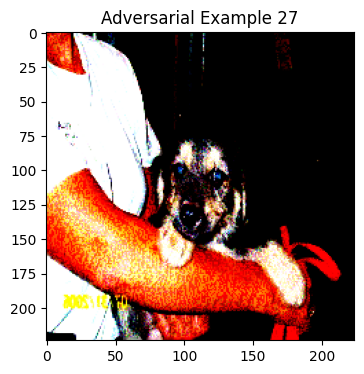

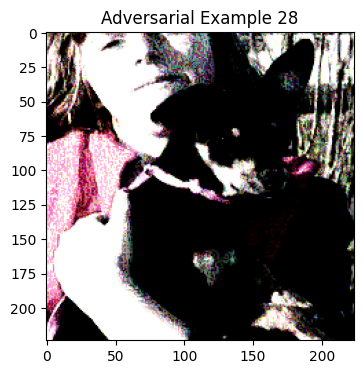

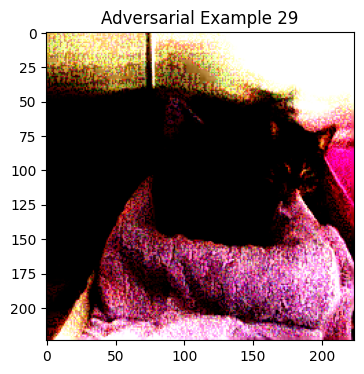

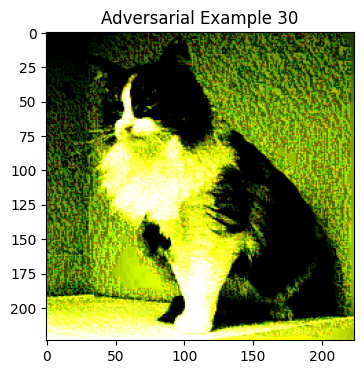

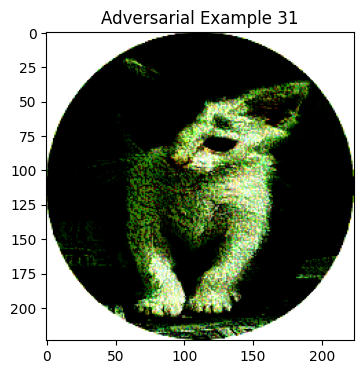

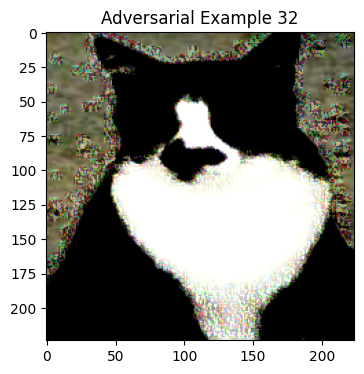

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
dataset, dataset_info = tfds.load('cats_vs_dogs', split='train', with_info=True, as_supervised=True)
num_classes = 2
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.2, upper=1.8)
    image = tf.image.per_image_standardization(image)
    label = tf.one_hot(label, num_classes)
    return image, label
dataset = dataset.map(preprocess_image)
num_samples = dataset_info.splits['train'].num_examples
num_train_samples = int(0.8 * num_samples)
num_val_samples = int(0.1 * num_samples)
num_test_samples = num_samples - num_train_samples - num_val_samples
train_dataset = dataset.take(num_train_samples)
remaining_dataset = dataset.skip(num_train_samples)
val_dataset = remaining_dataset.take(num_val_samples)
test_dataset = remaining_dataset.skip(num_val_samples)
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, epochs=5, validation_data=val_dataset)
latent_dim = 100
#GAN
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(3, activation='tanh'))
    return model
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model
generator = build_generator(latent_dim)
discriminator = build_discriminator((224, 224, 3))
art_classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=num_classes,
    input_shape=(224, 224, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
)
attack = FastGradientMethod(estimator=art_classifier, eps=0.2)
test_batch = next(iter(test_dataset))
test_images, test_labels = test_batch
adversarial_test_images = attack.generate(test_images.numpy(), y=test_labels.numpy())
num_adversarial_images = adversarial_test_images.shape[0]
print(f"Number of Adversarial Images: {num_adversarial_images}")
num_display = min(num_adversarial_images, 35)
for i in range(num_display):
    plt.figure(figsize=(8, 4))
    plt.imshow(adversarial_test_images[i])
    plt.title(f'Adversarial Example {i + 1}')
    plt.show()
    #As I mentioned before, I wanted to attempt to Combine both GAN and the Library which really helped my project, here you can see that I have been able to successfully confuse the model, and able to generate the images with different classes.


In [9]:
pip install adversarial-robustness-toolbox


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.0 MB/s eta 0:00:00
